### DataLoaders

We train LLMs to generate one word at a time. And therefore, we want to prepare the training data accordingly. For example, if you take one sentence as shown here, many input and output tokens can be prepared from this one sentence itself.

Here you can see that we have 7 input and output examples

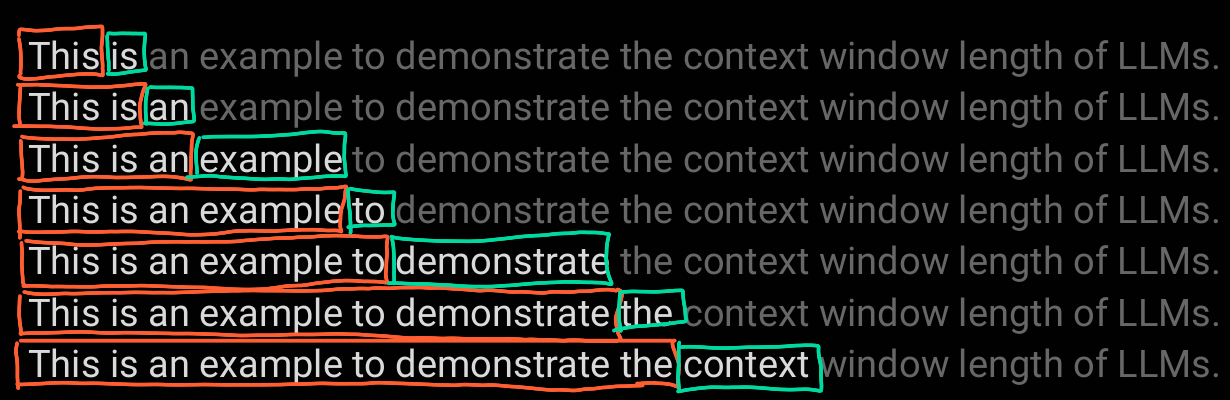

In [1]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')

In [2]:
with open("Data-Science-from-scratch/llm/the-verdict.txt","r",encoding="utf-8") as f:
    raw_text = f.read()
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

FileNotFoundError: [Errno 2] No such file or directory: 'Data-Science-from-scratch/llm/the-verdict.txt'

Let's set the context size to 4. This means that the input size cannot be more than this size. A max of 4 tokens are sent as an input to get the output.

In [5]:
context_size = 4
for i in range(1, context_size+1):
    context = enc_text[:i]
    desired = enc_text[i]

    print(context, "---->", desired)

[40] ----> 367
[40, 367] ----> 2885
[40, 367, 2885] ----> 1464
[40, 367, 2885, 1464] ----> 1807


In [6]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.2.1+cu121


In [7]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self,idx):
        return self.input_ids[idx], self.target_ids[idx]

In the __init__ method, we set up attributes that we can access later in the
 __getitem__ and __len__ methods. This could be file paths, file objects,
 database connectors, and so on. Since we created a tensor dataset that sits in
 memory, we are simply assigning X and y to these attributes, which are
 placeholders for our tensor objects.

 In the __getitem__ method, we define instructions for returning exactly one
 item from the dataset via an index. This means the features and the class
 label corresponding to a single training example or test instance. 

In [8]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt,tokenizer,max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    return dataloader


Let's test the dataloader with a batch size of 1 for an LLM with a context size of 4.

In [10]:
with open("Data-Science-from-scratch/llm/the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text =f.read()

In [25]:
dataloader = create_dataloader_v1(raw_text, batch_size=2, max_length=3, stride=2, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885],
        [2885, 1464, 1807]]), tensor([[ 367, 2885, 1464],
        [1464, 1807, 3619]])]


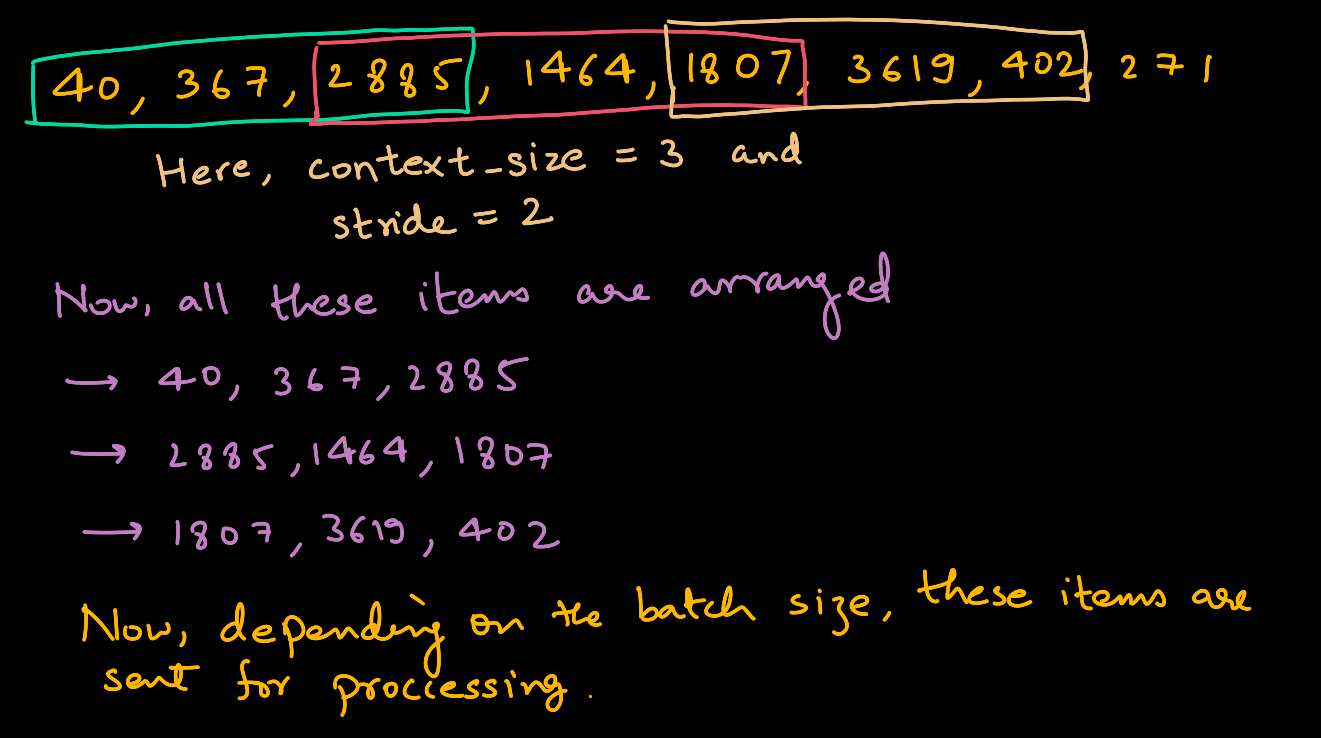

In [ ]:
for idx, (x,y) in enumerate(dataloader):
    print(f"Batch {idx+1}:",x,y)

This is a very important hyperparameter which is set during training of the model.
Now, in each of these batches, the prefix till index i for the input is used to predict the index i of the output